## Import required packages

In [57]:
import argparse
import torch
from PIL import Image
import pandas as pd
import os
from scipy.io import loadmat
from torch.utils import data
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision.io import read_image
from torchvision import datasets, models, transforms, utils
import numpy as np
import cv2
import torch.nn as nn
import matplotlib.pyplot as plt
# !pip install ipywidgets widgetsnbextension
# !jupyter nbextension enable --py widgetsnbextension

## Create parser

In [58]:
parser = argparse.ArgumentParser(description='PyTorch Pineapple Image Classification')
parser.add_argument('--model', default='ResNet18', type=str)
parser.add_argument('-j', '--workers', default=4, type=int, metavar='N',
                    help='number of data loading workers (default: 4)')
parser.add_argument('--epochs', default=50, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('-b', '--batch-size', default=32, type=int,
                    metavar='N')
parser.add_argument('--save-freq', default=10, type=int,
                    metavar='N', help='Save trained model every x batches')
parser.add_argument('--epoch-size', default=4029, type=int,
                    help='size of training set to use (default:4029, size of Pineapple dataset size)')
parser.add_argument('--save-model', action='store_true', default=True,
                        help='For Saving the current Model')
    
#args = parser.parse_args() # for command line
args = parser.parse_args(args=['--model', 'VGG16']) # for jupyter notebook (all use default value)

## 建立 Pytorch Dataset Class (Pineapple dataset)

In [59]:
class PineappleDataset(Dataset):
    def __init__(self, annotations_file, img_dir="./", transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, encoding="unicode_escape")
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.targets = self.img_labels.iloc[:, 1] # label of the dataset
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        #image = cv2.imread(img_path)
        image = read_image(img_path)
        #print(image.shape)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    def __len__(self):
        return len(self.img_labels)

## 實例化類別

Before split
Train data set: 4028
Test data set: 4028
After split
Train data set: 3222
Valid data set: 806
tensor([[[-0.7306, -0.7174, -0.7043,  ..., -0.6383, -0.6647, -0.6647],
         [-0.7306, -0.7306, -0.7174,  ..., -0.6515, -0.6647, -0.6647],
         [-0.7570, -0.7438, -0.7438,  ..., -0.5856, -0.5856, -0.5724],
         ...,
         [-0.9548, -0.9284, -0.9416,  ..., -0.9812, -0.9812, -0.9284],
         [-0.8361, -0.9021, -0.8361,  ..., -0.9812, -0.9812, -0.9284],
         [-0.6515, -0.7702, -0.7174,  ..., -0.9812, -0.9812, -0.9284]],

        [[-0.7339, -0.7079, -0.6948,  ..., -0.5645, -0.5905, -0.5905],
         [-0.7470, -0.7339, -0.7209,  ..., -0.5645, -0.5775, -0.5775],
         [-0.7730, -0.7600, -0.7470,  ..., -0.4732, -0.4732, -0.4602],
         ...,
         [-0.9686, -0.9556, -0.9686,  ..., -0.9947, -0.9947, -0.9425],
         [-0.8643, -0.9425, -0.9034,  ..., -0.9947, -0.9947, -0.9425],
         [-0.7079, -0.8252, -0.7861,  ..., -0.9947, -0.9947, -0.9425]],

        [

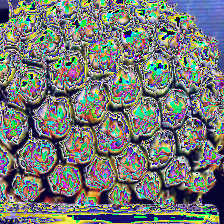

In [60]:
def show_pic(img):
    # display image 
    transform = transforms.ToPILImage()
    img = transform(img)
    img.show()
    

# Create train/valid transforms
train_transform = transforms.Compose([
    transforms.ToPILImage(), # to PIL format
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.2918, 0.2992, 0.2334], std=[0.2974, 0.3008, 0.2800]), # image = (image-mean) / std
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

valid_transform = transforms.Compose([
    transforms.ToPILImage(), # to PIL format
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.2918, 0.2992, 0.2334], std=[0.2974, 0.3008, 0.2800]), # image = (image-mean) / std
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create train/valid datasets
train_set = PineappleDataset(annotations_file='./training/pineapple_cropped_annotations.csv', transform=train_transform)
valid_set = PineappleDataset(annotations_file='./training/pineapple_cropped_annotations.csv', transform=valid_transform)


# Before split dataset
print("Before split")
print('Train data set:', len(train_set))
print('Test data set:', len(valid_set))

# Random split
train_set_size = int(len(train_set) * 0.8)
valid_set_size = len(train_set) - train_set_size
train_set, valid_set = data.random_split(train_set, [train_set_size, valid_set_size])

# After split
print('='*30)
print("After split")
print('Train data set:', len(train_set))
print('Valid data set:', len(valid_set))


first_img = train_set[0]
img, label = first_img
print(img)
print(f'img_mean: {img.mean(dim=[1,2])}')
print(f'img_std: {img.std(dim=[1,2])}')
print(img.shape)
show_pic(img)



# Create train/valid loaders
train_loader = DataLoader(
    dataset=train_set, batch_size=args.batch_size, shuffle=True, num_workers=args.workers)
test_loader = DataLoader(
    dataset=valid_set, batch_size=args.batch_size, shuffle=False, num_workers=args.workers)

## 定義類神經網路模型

In [61]:
# using ResNet18 pre-trained model
# class ResNet18(nn.Module):
#     def __init__(self):
#         super(ResNet18, self).__init__()

#         # Define proportion or neurons to dropout
# #         self.dropout = nn.Dropout(0.2)
        
#         # 載入 ResNet18 類神經網路結構
#         self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

#         # 鎖定 ResNet18 預訓練模型參數
#         # for param in self.model.parameters():
#         #   param.requires_grad = False
        
#         # 修改輸出層輸出數量
#         self.model.fc = nn.Linear(1000, 4)


#     def forward(self, x):
#         x = self.model(x)
#         return x

In [62]:
# using VGG16 pre-trained model 
class Vgg16(nn.Module):
    def __init__(self):
        super(Vgg16, self).__init__()

        # Define proportion or neurons to dropout
#         self.dropout = nn.Dropout(0.2)
        
        # 載入 VGG16 類神經網路結構
        self.model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)

        # 鎖定 VGG16 預訓練模型參數
        # for param in self.model.parameters():
        #   param.requires_grad = False
        
        in_features = self.model._modules['classifier'][-1].in_features
        out_features = 4
        self.model._modules['classifier'][-1] = nn.Linear(in_features, out_features, bias=True)
        print(self.model._modules['classifier'])
        

    def forward(self, x):
        x = self.model(x)
        return x

In [63]:
# 若 CUDA 環境可用，則使用 GPU 計算，否則使用 CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
# 建立類神經網路模型，並放置於 GPU 或 CPU 上
model = Vgg16().to(device)
print(model)

Using cuda device
Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=4, bias=True)
)
Vgg16(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     

In [64]:
# 損失函數
loss_fn = nn.CrossEntropyLoss()

# 學習優化器
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

# 訓練模型
def train(dataloader, model, loss_fn, optimizer):
    # 資料總筆數
    size = len(dataloader.dataset)
    
     # 批次數量
    num_batches = len(dataloader)
    
    # 定義平均的 loss 與 Acc
    total_loss, total_correct = 0, 0
    
    # 將模型設定為訓練模式
    model.train()

    # 批次讀取資料進行訓練
    for batch, (X, y) in enumerate(dataloader):
        # 將資料放置於 GPU 或 CPU
        X, y = X.to(device), y.to(device)

        pred = model(X)         # 計算預測值
        loss = loss_fn(pred, y) # 計算損失值（loss）
        total_loss += loss.item()
        total_correct += (pred.argmax(1) == y).type(torch.float).sum().item()  # 計算預測正確數量的加總值
        optimizer.zero_grad()   # 重設參數梯度（gradient）
        loss.backward()         # 反向傳播（backpropagation）
        optimizer.step()        # 更新參數

        # 輸出訓練過程資訊
        if batch % args.save_freq == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    return total_loss/num_batches, 100*total_correct/size
    

In [65]:
# 測試模型
def test(dataloader, model, loss_fn):
    # 資料總筆數
    size = len(dataloader.dataset)

    # 批次數量
    num_batches = len(dataloader)

    # 將模型設定為驗證模式
    model.eval()

    # 初始化數值
    test_loss, correct = 0, 0

    # 驗證模型準確度
    with torch.no_grad():  # 不要計算參數梯度
        for X, y in dataloader:
            # 將資料放置於 GPU 或 CPU
            X, y = X.to(device), y.to(device)

            # 計算預測值
            pred = model(X)

            # 計算損失值的加總值
            test_loss += loss_fn(pred, y).item()

            # 計算預測正確數量的加總值
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # 計算平均損失值與正確率
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return test_loss, 100*correct

In [66]:
def print_loss(train_loss, test_loss):
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title("Loss")
    plt.plot(train_loss,  label = "Training") # training loss curve
    plt.plot(test_loss,  label = "Validation") # training loss curve
    plt.legend(loc = 'upper left')
    fig = plt.gcf() # get current figure
    plt.show()
    return fig
    
def print_acc(train_acc, test_acc):
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy(%)')
    plt.title("Accuracy")
    plt.plot(train_acc,  label = "Training") # training loss curve
    plt.plot(test_acc,  label = "Validation") # training loss curve
    plt.legend(loc = 'upper left')
    fig = plt.gcf() # get current figure
    plt.show()
    return fig
    
def save_result_fig(args, name, version=0):
    result_path = os.path.join('Results', args.model,
                                  'epochsize_{}-bsize_{}-tepochs_{}_{}_{}_Fig.jpg'.format(args.epoch_size, args.batch_size, args.epochs, name, version))
    if os.path.exists(result_path):
        return save_result_fig(args, name, version+1)
    else:    
        return result_path

完成！


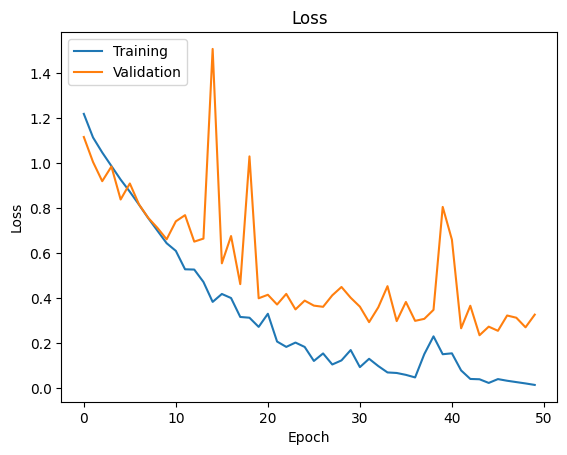

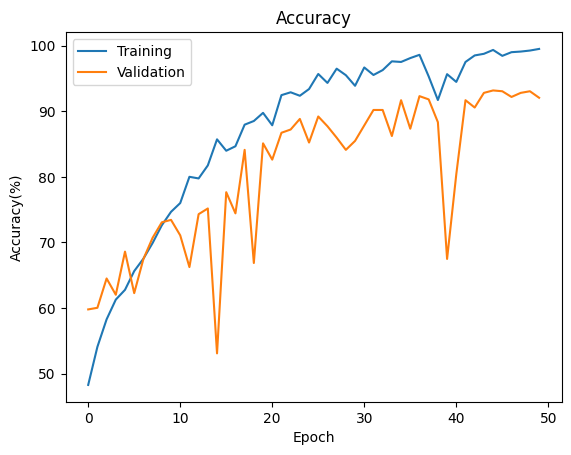

In [68]:
avg_loss, avg_acc = 0, 0
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

# # 開始訓練模型
print(args)
for t in range(args.epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    avg_loss, avg_acc = train(train_loader, model, loss_fn, optimizer)
    train_loss_list.append(avg_loss)
    train_acc_list.append(avg_acc)
    avg_loss, avg_acc = test(test_loader, model, loss_fn)
    test_loss_list.append(avg_loss)
    test_acc_list.append(avg_acc)
print("完成！")
if args.save_model:
    path = os.path.join("Model", args.model, "pineapple_model.pt")
    torch.save(model.state_dict(), path)

fig_loss = print_loss(train_loss_list, test_loss_list)
fig_loss_path = save_result_fig(args, "Loss")
fig_acc = print_acc(train_acc_list, test_acc_list)
fig_acc_path = save_result_fig(args, "Acc")
 # 將訓練結果存起來
fig_loss.savefig(fig_loss_path, bbox_inches='tight')
fig_acc.savefig(fig_acc_path, bbox_inches='tight')